In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
import umap
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_excel('1400.xlsx')

In [3]:
df.head(10)

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0
5,1011-As-83,25.8,500.0,19.379845,265.466,1,0,12.36,CC[N+](C)(CC)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,55.0
6,1012-Ya-201,39.4,498.0,12.639594,279.493,1,0,12.36,CC[N+](CC)(CC)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,56.0
7,1013-Ya-179,26.6,500.0,18.796992,570.997,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CC[N+](CC)(CC)...,57.0
8,1014-Ya-177,160.0,500.0,3.125000,570.997,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,58.0
9,1015-As-70,500.0,500.0,1.000000,605.015,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,59.0


In [4]:
df = df.rename(columns = {'IC50, mmg/ml': "IC50"})
df_smiles = df[['IC50', 'SMILES']]

In [5]:
def generate_fingerprints(smiles_list):
    fps = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((1,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    return np.array(fps)

In [6]:
smiles_list = df_smiles['SMILES'].tolist()
fps = generate_fingerprints(smiles_list)

[21:20:43] Conflicting single bond directions around double bond at index 55.
[21:20:43]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [7]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(fps)

/home/user/conda/envs/chem/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(embedding)

In [10]:
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # -1 indicates noise in DBSCAN
n_noise = list(clusters).count(-1)

In [11]:
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 43
Estimated number of noise points: 0


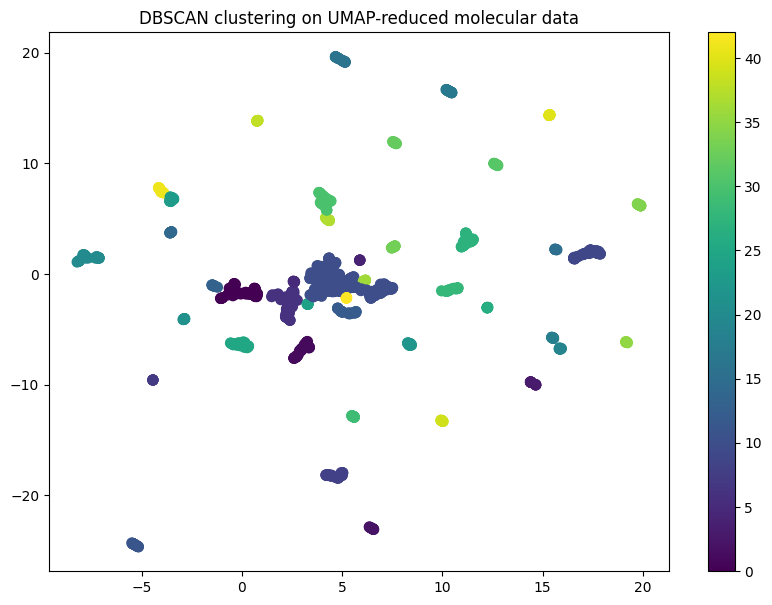

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=50, cmap='viridis')
plt.title("DBSCAN clustering on UMAP-reduced molecular data")
plt.colorbar()
plt.show()